In [32]:
# 1. Load & inspect columns
import pandas as pd

df = pd.read_csv('hour.csv')
print(df.columns)         # analogous to your example’s df.columns


Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


In [33]:
# 2. Peek at the first few rows
df.head()                 # analogous to your example’s df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [34]:
# 3. Quick summary & missingness
df.info()                 # analogous to df.info() in polling notebook
df.describe().T           # gives you min/mean/max for each numeric column
df.isna().sum()           # check for any nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [35]:
# 4. Rename target for clarity
df.rename(columns={'cnt':'rentals'}, inplace=True)

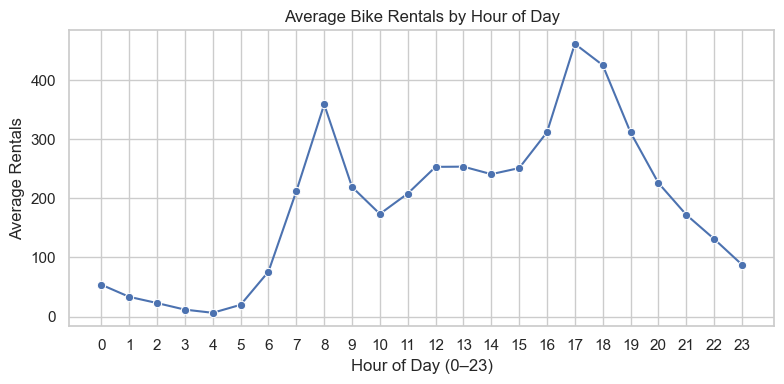

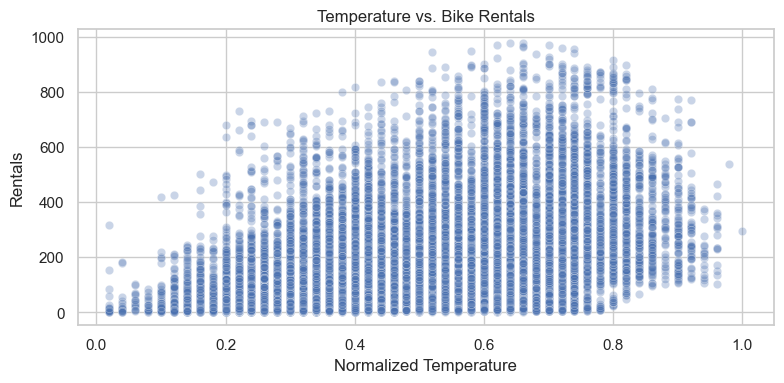

In [36]:
# 5. Simple EDA plots (corrected)

import matplotlib.pyplot as plt
import seaborn as sns

# ensure plots use a clean style
sns.set_theme(style="whitegrid")

# 5a. Avg. rentals by hour
# — explicitly aggregate only the numeric 'rentals' column
hourly = df.groupby('hr', as_index=False)['rentals'].mean()

plt.figure(figsize=(8, 4))
sns.lineplot(
    data=hourly,
    x='hr',
    y='rentals',
    marker='o'
)
plt.title('Average Bike Rentals by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Rentals')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# 5b. Rentals vs. Temperature
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=df,
    x='temp',
    y='rentals',
    alpha=0.3
)
plt.title('Temperature vs. Bike Rentals')
plt.xlabel('Normalized Temperature')
plt.ylabel('Rentals')
plt.tight_layout()
plt.show()

In [37]:
# 6. Feature engineering (categoricals → dummies, cyclical encoding)
df['season']     = df['season'].astype('category')
df['weathersit'] = df['weathersit'].astype('category')
df = pd.get_dummies(df, columns=['season','weathersit'], drop_first=True)

# cyclical hour
import numpy as np
df['hr_sin'] = np.sin(2*np.pi * df['hr']/24)
df['hr_cos'] = np.cos(2*np.pi * df['hr']/24)

In [38]:
# 7. Train/test split & scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['instant','dteday','casual','registered','rentals'], axis=1)
y = df['rentals']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

scaler = StandardScaler().fit(X_train.select_dtypes(float))
X_train[X_train.select_dtypes(float).columns] = scaler.transform(X_train.select_dtypes(float))
X_test[X_test.select_dtypes(float).columns]   = scaler.transform(X_test.select_dtypes(float))

In [39]:
# 8. Baseline model & evaluation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression().fit(X_train, y_train)
pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2   = r2_score(y_test, pred)

print(f"LR RMSE: {rmse:.2f}")
print(f"LR R²  : {r2:.3f}")

LR RMSE: 125.81
LR R²  : 0.508


In [40]:
# 9. RandomForest + grid‐search (with handle_unknown='ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# rebuild a small pipeline to demo grid‐search
cat_feats = [c for c in ['weekday','workingday'] if c in df.columns]
num_feats = [c for c in X_train.columns if c not in cat_feats]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_feats),
])

pipe = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [100,200],
    'model__max_depth'   : [10,20,None]
}

gs = GridSearchCV(pipe, param_grid, cv=3,
                  scoring='neg_root_mean_squared_error',
                  n_jobs=-1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV RMSE:", -gs.best_score_)

Best params: {'model__max_depth': 20, 'model__n_estimators': 200}
Best CV RMSE: 46.14281293081806


Test RMSE: 42.68
Test R²  : 0.943


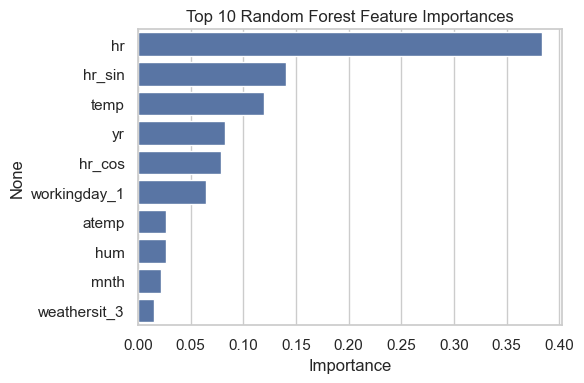

In [41]:
# 10. Final test‐set evaluation & feature importance
best = gs.best_estimator_
# 1) Test-set evaluation
pred_best = best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_best))
r2   = r2_score(y_test, pred_best)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²  : {r2:.3f}")

# 2) Pull out feature-names from the pipeline
# figure out whether you named your CT step "pre" or "prep"
ct_name = 'prep' if 'prep' in best.named_steps else 'pre'
col_trans = best.named_steps[ct_name]  # ColumnTransformer

# get the categorical transformer
cat_trans = col_trans.named_transformers_['cat']

# if it was wrapped in a Pipeline, unwrap it
if hasattr(cat_trans, 'named_steps'):
    ohe = cat_trans.named_steps['onehot']
else:
    ohe = cat_trans

# now safely get the OHE feature names
cat_feature_names = ohe.get_feature_names_out(cat_feats)

# numeric features you scaled
num_features = num_feats

all_features = list(num_features) + list(cat_feature_names)

# 3) Extract and plot importances
importances = best.named_steps['model'].feature_importances_
fi = pd.Series(importances, index=all_features).nlargest(10)

plt.figure(figsize=(6,4))
sns.barplot(x=fi.values, y=fi.index)
plt.title("Top 10 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()